# Goal: analyze coursera Data Science course landscape and identify opportunities for new courses

In [36]:
import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import re
import plotly.express as px
import seaborn as sns

from helpers import strip_spaces, lowercase_data, convert_metric_prefix_to_numeric

df = pd.read_csv("coursera_data.csv", index_col=0)
df = lowercase_data(df)
df = strip_spaces(df)

In [2]:
missing_values = pd.Series(df.isnull().sum(), name="Missing Values")
missing_values

course_title                0
course_organization         0
course_certificate_type     0
course_rating               0
course_difficulty           0
course_students_enrolled    0
Name: Missing Values, dtype: int64

In [3]:
duplicate_values = pd.Series(df.duplicated().sum(), name="Duplicate Values")
duplicate_values

0    0
Name: Duplicate Values, dtype: int64

We see that there no duplicate or no missing values, so we won't be handling them. Other values are already in the correct format and there seem to be no other data quality issues (e.g. incorrect data types, inconsistent values).

Now, let's filter just courses related to Data Science

In [4]:
data_science_keywords = [
    r'\bData Science\b', r'\bData Analysis\b', r'\bPython\b', r'\bMachine Learning\b',
    r'\bAI\b', r'\bArtificial Intelligence\b', r'\bDeep Learning\b', r'\bData Engineering\b',
    r'\bBig Data\b', r'\bStatistics\b', r'\bData Mining\b', r'\bData Visualization\b', r'\bSQL\b',
    r'\bNeural Networks\b',
    r'\bNatural Language Processing\b', r'\bNLP\b', r'\bData Analytics\b',
    r'\bPredictive Analytics\b', r'\bBusiness Intelligence\b', r'\bBI\b',
    r'\bData Modeling\b', r'\bDatabase\b', r'\bNoSQL\b', r'\bHadoop\b', r'\bSpark\b',
    r'\bTensorFlow\b', r'\bTableau\b', r'\bPower BI\b', r'\bSAS\b', r'\bData Warehouse\b',
    r'\bETL\b', r'\bFeature Engineering\b', r'\bRegression\b', r'\bClassification\b',
    r'\bClustering\b', r'\bTime Series\b', r'\bForecasting\b', r'\bStatistical Learning\b', r'\bBayesian\b',
    r'\bData Management\b'
]


def contains_data_science_keyword(title):
    return any(re.search(keyword, title, re.IGNORECASE) for keyword in data_science_keywords)


data_science_df = df[df['course_title'].apply(contains_data_science_keyword)]
data_science_df = data_science_df.reset_index(drop=True)

# Name index column to 'id' for clarity
data_science_df = data_science_df.reset_index().rename(columns={'index': 'id'}).set_index('id')

# Convert numeric values from e.g. '48k' to '48000' whole numbers for `course_students_enrolled`
data_science_df['course_students_enrolled'] = convert_metric_prefix_to_numeric(
    data_science_df['course_students_enrolled'])

Let's add a category for each Data Science course, as 'Data Science' is just too broad to describe each course:
- Courses can have overlapping subjects (e.g. Data Science can cover Machine Learning, but Machine Learning can also be a separate course). We'll categorize based on the most specific subject mentioned in the title. E.g. "Data Science and Machine Learning" will be categorized as Machine Learning, not Data Science. This is a simplification but should work well for most cases. We can always refine it later if needed.
- Python or R programming is a common prerequisite for Data Science, but they are not a Data Science courses per se. However, it's still relevant to include them.

In [5]:
def categorize_course(title):
    title = title.lower()  # Convert to lowercase for easier matching

    # Define our categories and their associated keywords
    ds_subject_areas = {
        'Programming': [r'\bpython\b', r'\br programming\b', r'\bsql\b'],
        'Machine Learning': [r'\bmachine learning\b', r'\btensorflow\b'],
        'Big Data': [r'\bbig data\b', r'\bhadoop\b', r'\bspark\b', r'\bsas\b', r'\bdata warehouse\b',
                     r'\bdata warehousing\b'],
        'Data Visualization': [r'\bdata visualization\b', r'\btableau\b', r'\bpower bi\b', r'\btime series\b'],
        'Data Engineering': [r'\bdata engineering\b', r'\btableau\b', r'\bpower bi\b', r'\btime series\b'],
        'AI': [r'\bai\b', r'\bartificial intelligence\b',
               r'\bdeep learning\b',
               r'\bneural networks\b'],
        'Data Science': [r'\bdata science\b', r'\bdata analysis\b', r'\bdata analytics\b', r'\bdata mining\b',
                         r'\bdata management\b'],
        'Statistics': [r'\bstatistics\b', r'\bbayesian\b', r'\bregression\b', r'\bclassification\b', r'\bclustering\b'],
    }

    for subject_area, patterns in ds_subject_areas.items():
        if any(re.search(pattern, title) for pattern in patterns):
            return subject_area


data_science_df['subject_area'] = data_science_df['course_title'].apply(categorize_course)
data_science_df

,course_title,course_organization,course_certificate_type,course_rating,course_difficulty,course_students_enrolled,subject_area
id,,,,,,,
0,a crash course in data science,johns hopkins university,course,4.5,mixed,130000.0,Data Science
1,ai for everyone,deeplearning.ai,course,4.8,beginner,350000.0,AI
2,ai for medical treatment,deeplearning.ai,course,4.8,intermediate,2400.0,AI
3,ai foundations for everyone,ibm,specialization,4.7,beginner,61000.0,AI
4,ai for medical diagnosis,deeplearning.ai,course,4.7,intermediate,12000.0,AI
...,...,...,...,...,...,...,...
123,what is data science?,ibm,course,4.7,beginner,260000.0,Data Science
124,математика и python для анализа данных,e-learning development fund,course,4.8,beginner,67000.0,Programming
125,основы программирования на python,national research university higher school of ...,course,4.6,beginner,83000.0,Programming


# Now, let's analyze Data Science courses and suggest improvements/new courses by answering the questions below.

### 1. What are the top 10 most enrolled courses regardless of subject area, and what subjects do they cover?

In [22]:
top_10_enrolled_courses = data_science_df[
    ['course_title', 'course_organization', 'course_students_enrolled', 'subject_area']].nlargest(
    10, 'course_students_enrolled')

fig = px.bar(top_10_enrolled_courses,
             x='course_students_enrolled',
             y='course_title',
             color='subject_area',
             labels={'course_students_enrolled': 'Number of Students Enrolled',
                     'course_title': 'Course Title',
                     'subject_area': 'Subject Area'},
             title='Top 10 Most Popular Data Science Courses on Coursera',
             hover_data=['course_organization', 'subject_area'])

fig.update_layout(yaxis={'categoryorder': 'total ascending'},
                  xaxis_title="Number of Students Enrolled",
                  yaxis_title="Course Title",
                  height=600,
                  width=1200)

fig.update_xaxes(tickformat=",.0f")

fig.show()

- "Machine Learning" course leads in enrollment, indicating high demand for ML skills.
- Python is Fundamental: three top courses focus on Python.
- "Long Tail" Distribution: enrollment drops sharply after top courses, suggesting a few highly popular courses and many with moderate enrollment.

### 2. Are there any difficulty levels (Beginner, Intermediate, Advanced, Mixed) that are underrepresented in popular subject areas?

In [23]:
summary_df = data_science_df.groupby(["subject_area", "course_difficulty"]).size().reset_index(name="count")

fig = px.bar(summary_df,
             x="subject_area",
             y="count",
             color="course_difficulty",
             title="Distribution of Difficulty Levels Across Subject Areas",
             labels={"subject_area": "Subject Area", "count": "Number of Courses",
                     "course_difficulty": "Difficulty Level"},
             category_orders={"course_difficulty": ["beginner", "intermediate", "advanced", "mixed"]},
             color_discrete_map={"beginner": "green", "intermediate": "blue", "advanced": "red", "mixed": "purple"})

fig.update_layout(barmode="group", xaxis_title="Subject Area", yaxis_title="Number of Courses")

fig.show()

- Varying difficulty distributions: each subject area has a different distribution of difficulty levels. Some areas are heavily skewed towards certain difficulty levels.
- Beginner-friendly focus: most subject areas have a significant number of beginner courses.
- Programming and Data Science have the highest number of beginner courses.
- AI and Machine Learning have more intermediate courses than beginner ones. This suggests these fields may cater more to those with some prior knowledge.
- Advanced course scarcity: advanced courses are generally underrepresented across all subject areas. Only a few subject areas (AI, Machine Learning, Data Science) offer advanced courses.
- Mixed difficulty courses: present in most subject areas, but not dominant in any. Might indicate courses that cater to a wide range of skill levels.
- Programming, Data Science, and Machine Learning have the most courses overall. This could indicate higher demand or more developed courses in these areas.
- Data Engineering and Data Visualization have fewer courses overall. This might suggest these are more specialized or emerging fields.
- Potential gaps:
    - Lack of advanced courses in areas like Big Data and Statistics.
    - Few intermediate courses in Data Visualization.

### 3. Are there any high-rated courses with relatively low enrollment, suggesting potential for growth with better marketing?

In [25]:
import pandas as pd
import plotly.express as px

data_science_df['course_students_enrolled'] = pd.to_numeric(
    data_science_df['course_students_enrolled'].replace(',', '', regex=True), errors='coerce')
data_science_df['course_rating'] = pd.to_numeric(data_science_df['course_rating'], errors='coerce')

median_enrollment = data_science_df['course_students_enrolled'].median()

high_rated_low_enrollment = data_science_df[(data_science_df['course_rating'] >= 4.8) &
                                            (data_science_df['course_students_enrolled'] < median_enrollment)]

fig = px.scatter(high_rated_low_enrollment,
                 x='course_students_enrolled',
                 y='course_rating',
                 hover_name='course_title',
                 size='course_students_enrolled',
                 size_max=50,
                 title='High-Rated Courses with Low Enrollment',
                 labels={'course_students_enrolled': 'Number of Students Enrolled',
                         'course_rating': 'Course Rating'})

fig.add_vline(x=median_enrollment, line_dash="dash", line_color="red", annotation_text="Median Enrollment",
              annotation_position="top right")

fig.add_hline(y=4.8, line_dash="dash", line_color="green", annotation_text="High Rating Threshold",
              annotation_position="left")

fig.update_layout(xaxis_type="log",  # Use log scale for enrollment
                  xaxis_title="Number of Students Enrolled (log scale)",
                  yaxis_title="Course Rating")

fig.show()

- Cluster of high-quality courses: there's a significant cluster of courses with ratings at or above 4.8 (the green line), indicating high quality.
- Enrollment disparity: these highly-rated courses have enrollments below the median (red dashed line), suggesting they could be more popular. Using the median enrollment as a threshold helps identify courses below the "middle" enrollment, which is less influenced by extremely popular courses that might skew an average.
- Hidden gems: one course stands out with an exceptionally high rating (around 4.9) and relatively low enrollment ("Getting Started with SAS Programming"), presenting an opportunity for growth.
"AI for Medical Treatment" also seems like a highly rated course with low enrollment, suggesting potential for growth with better marketing.
- The visualization highlights that course quality (as measured by ratings) doesn't always correlate with popularity (as measured by enrollment).
- It might be worth to:
    - investigate why these courses have low enrollment
    - consider marketing strategies to increase their visibility
    - explore whether these courses could be expanded or improved to attract more students

### 4. Are there any gaps in the difficulty progression (Beginner to Advanced) within popular subject areas?

In [26]:
difficulty_order = ['beginner', 'intermediate', 'advanced', 'mixed']

top_subjects = data_science_df['subject_area'].value_counts().nlargest(5).index

df_grouped = data_science_df[data_science_df['subject_area'].isin(top_subjects)].groupby(
    ['subject_area', 'course_difficulty']).size().reset_index(name='count')

fig = px.bar(df_grouped,
             x='subject_area',
             y='count',
             color='course_difficulty',
             title='Distribution of Difficulty Levels Across Popular Subject Areas',
             labels={'subject_area': 'Subject Area', 'count': 'Number of Courses',
                     'course_difficulty': 'Difficulty Level'},
             category_orders={'course_difficulty': difficulty_order, 'subject_area': top_subjects})

fig.update_layout(barmode='stack', xaxis_title="Subject Area", yaxis_title="Number of Courses")

fig.show()

df_grouped.pivot(index='subject_area', columns='course_difficulty', values='count').fillna(0)

# Identify gaps
gaps = []
for subject in top_subjects:
    subject_difficulties = set(df_grouped[df_grouped['subject_area'] == subject]['course_difficulty'])
    missing_difficulties = set(difficulty_order) - subject_difficulties
    if missing_difficulties:
        gaps.append(f"{subject}: Missing {', '.join(missing_difficulties)}")

gaps

['Programming: Missing advanced',
 'AI: Missing mixed',
 'Statistics: Missing advanced']

- Overall distribution:
  - Programming has the highest number of courses, followed by Data Science and Machine Learning
  - AI and Statistics have fewer courses overall compared to other areas

- Beginner-Level courses:
  - Abundant in Programming and Data Science
  - Less common in Machine Learning and AI, suggesting these might be more advanced fields

- Intermediate-Level courses:
  - Well-represented across all subject areas
  - Particularly dominant in Machine Learning and AI

- Advanced-Level Courses:
  - Generally fewer across all subjects
  - Most prevalent in Machine Learning and AI
  - Notably absent in Programming and Statistics

- Mixed-Level Courses:
  - Present in all areas except AI
  - Most common in Programming and Data Science

- Identified Gaps and Opportunities:
  - Programming: Lacks advanced courses
  - AI: No mixed-level courses
  - Statistics: Absence of advanced courses
  - Data Science and Machine Learning: No significant gaps

- Recommendations:
  - Develop advanced Programming courses for data science applications
  - Create mixed-level AI courses for flexible learning paths
  - Introduce advanced Statistics courses for data science professionals
  - Maintain comprehensive offerings in Data Science and Machine Learning
  - Consider balancing course difficulty levels, especially in Programming and Statistics
  - Explore interdisciplinary courses combining advanced topics across subject areas

### 6. Are there any in-demand skills or technologies that are underrepresented in the current course offerings?

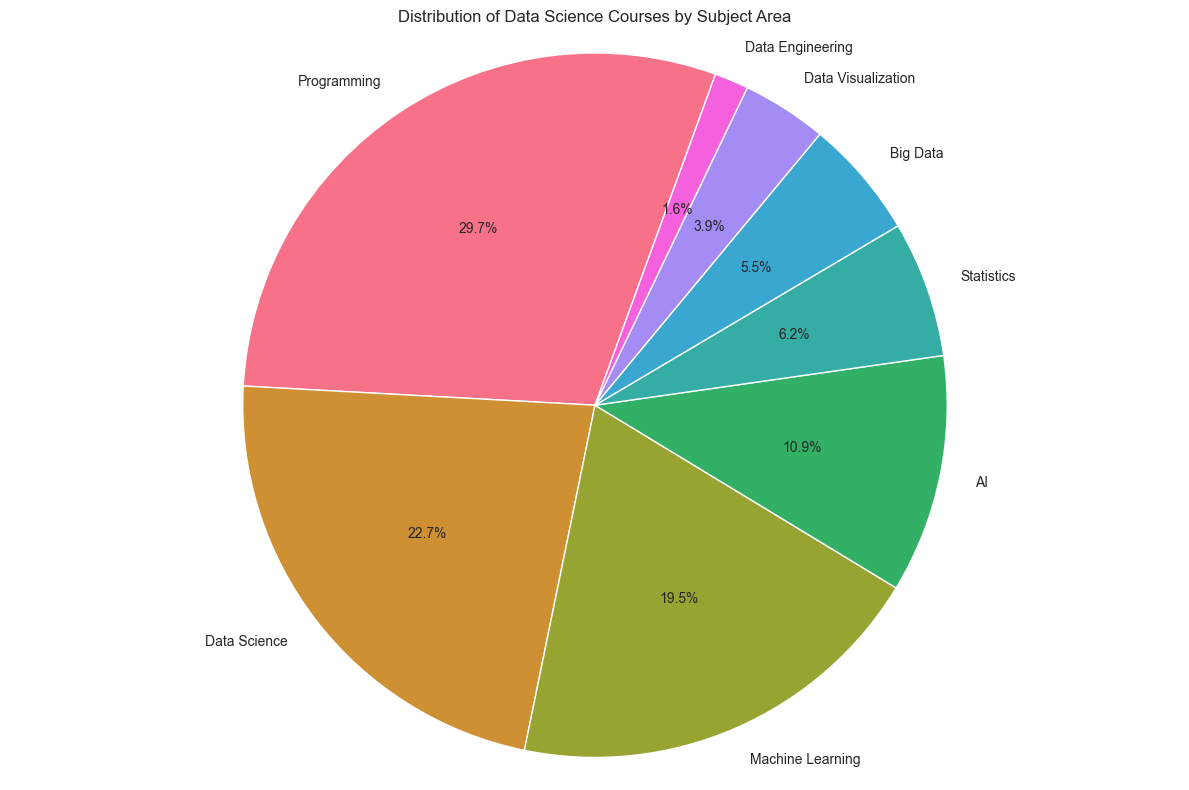

In [29]:
subject_area_counts = data_science_df['subject_area'].value_counts()
subject_area_percentages = (subject_area_counts / len(data_science_df)) * 100

plt.figure(figsize=(12, 8))
plt.pie(subject_area_percentages, labels=subject_area_percentages.index, autopct='%1.1f%%', startangle=70)
plt.title('Distribution of Data Science Courses by Subject Area')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

-  Gaps:
    - Data Engineering courses are significantly fewer, suggesting a possible gap in the curriculum
    - Data Visualization and Big Data courses are also relatively underrepresented
    - Statistics courses, crucial for data science, might be underrepresented given their importance

- Possible reasons for current distribution:
    - High demand for programming skills as a foundational requirement, not just in data science
    - Popularity and hype around AI and Machine Learning driving course creation
    - Data Engineering might be considered more specialized, leading to fewer offerings

- Potential new courses:
    - Increase offerings in Data Engineering, Data Visualization, and Big Data

### 7. What is the distribution of course types (individual courses, specializations, professional certificates) across different subjects, and are there imbalances?

In [18]:
course_type_distribution = data_science_df.groupby(['subject_area', 'course_certificate_type']).size().unstack(
    fill_value=0)

course_type_percentage = course_type_distribution.div(course_type_distribution.sum(axis=1), axis=0) * 100

melted_df = course_type_percentage.reset_index().melt(id_vars=['subject_area'],
                                                      var_name='course_type',
                                                      value_name='percentage')

fig = px.bar(melted_df, x='subject_area', y='percentage', color='course_type',
             title='Distribution of Course Types Across Subject Areas',
             labels={'subject_area': 'Subject Area', 'percentage': 'Percentage', 'course_type': 'Course Type'},
             category_orders={'course_type': ['COURSE', 'SPECIALIZATION', 'PROFESSIONAL CERTIFICATE']})

fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total descending'})
fig.show()

course_type_distribution

course_certificate_type,course,professional certificate,specialization
subject_area,,,
AI,8,2,4
Big Data,2,2,3
Data Engineering,0,1,1
Data Science,15,1,13
Data Visualization,4,0,1
Machine Learning,14,0,11
Programming,28,1,9
Statistics,5,0,3


### 8. Are there any subject areas with high enrollment but lower average ratings, indicating a need for improved course quality?

In [34]:
subject_summary = data_science_df.groupby('subject_area').agg({
    'course_rating': 'mean',
    'course_students_enrolled': 'sum'
}).reset_index()

import plotly.graph_objects as go

# Scatter plot
fig1 = px.scatter(subject_summary,
                  x='course_students_enrolled',
                  y='course_rating',
                  size='course_students_enrolled',
                  color='subject_area',
                  hover_name='subject_area',
                  text='subject_area',
                  title='Course Ratings vs. Enrollment by Subject Area',
                  labels={'course_students_enrolled': 'Total Enrollment',
                          'course_rating': 'Average Rating',
                          'subject_area': 'Subject Area'},
                  trendline='ols')

fig1.update_traces(textposition='top center')
fig1.update_layout(xaxis_type="log",
                   xaxis_title="Total Enrollment (log scale)",
                   yaxis_title="Average Rating")

# Adjust size of points for better visibility
fig1.update_traces(
    marker=dict(sizemin=5, sizeref=2. * max(subject_summary['course_students_enrolled']) / (40. ** 2), sizemode='area'))

fig1.show()

# Box plot
course_counts = data_science_df['subject_area'].value_counts()
median_ratings = data_science_df.groupby('subject_area')['course_rating'].median().sort_values(ascending=False)

fig2 = go.Figure()
for subject in median_ratings.index:
    fig2.add_trace(go.Box(
        y=data_science_df[data_science_df['subject_area'] == subject]['course_rating'],
        name=f"{subject}<br>({course_counts[subject]} courses)",
        boxmean=True
    ))

fig2.update_layout(
    title='Distribution of Course Ratings by Subject Area',
    xaxis_title='Subject Area (number of courses)',
    yaxis_title='Course Rating',
    showlegend=False
)

fig2.show()

- Potential areas for improvement:
    - Data Science: given high enrollment but lower average rating, focus on improving course quality
    - Data Engineering: consider expanding offerings and improving existing courses
    - Data Visualization: has lower enrollment and ratings, may need content and marketing improvements

### 9. The analyzed dataset is from 2020, as indicated by the "Updated 4 years ago" description on the Kaggle website. Are there any trends in the data science course landscape that have emerged since then?

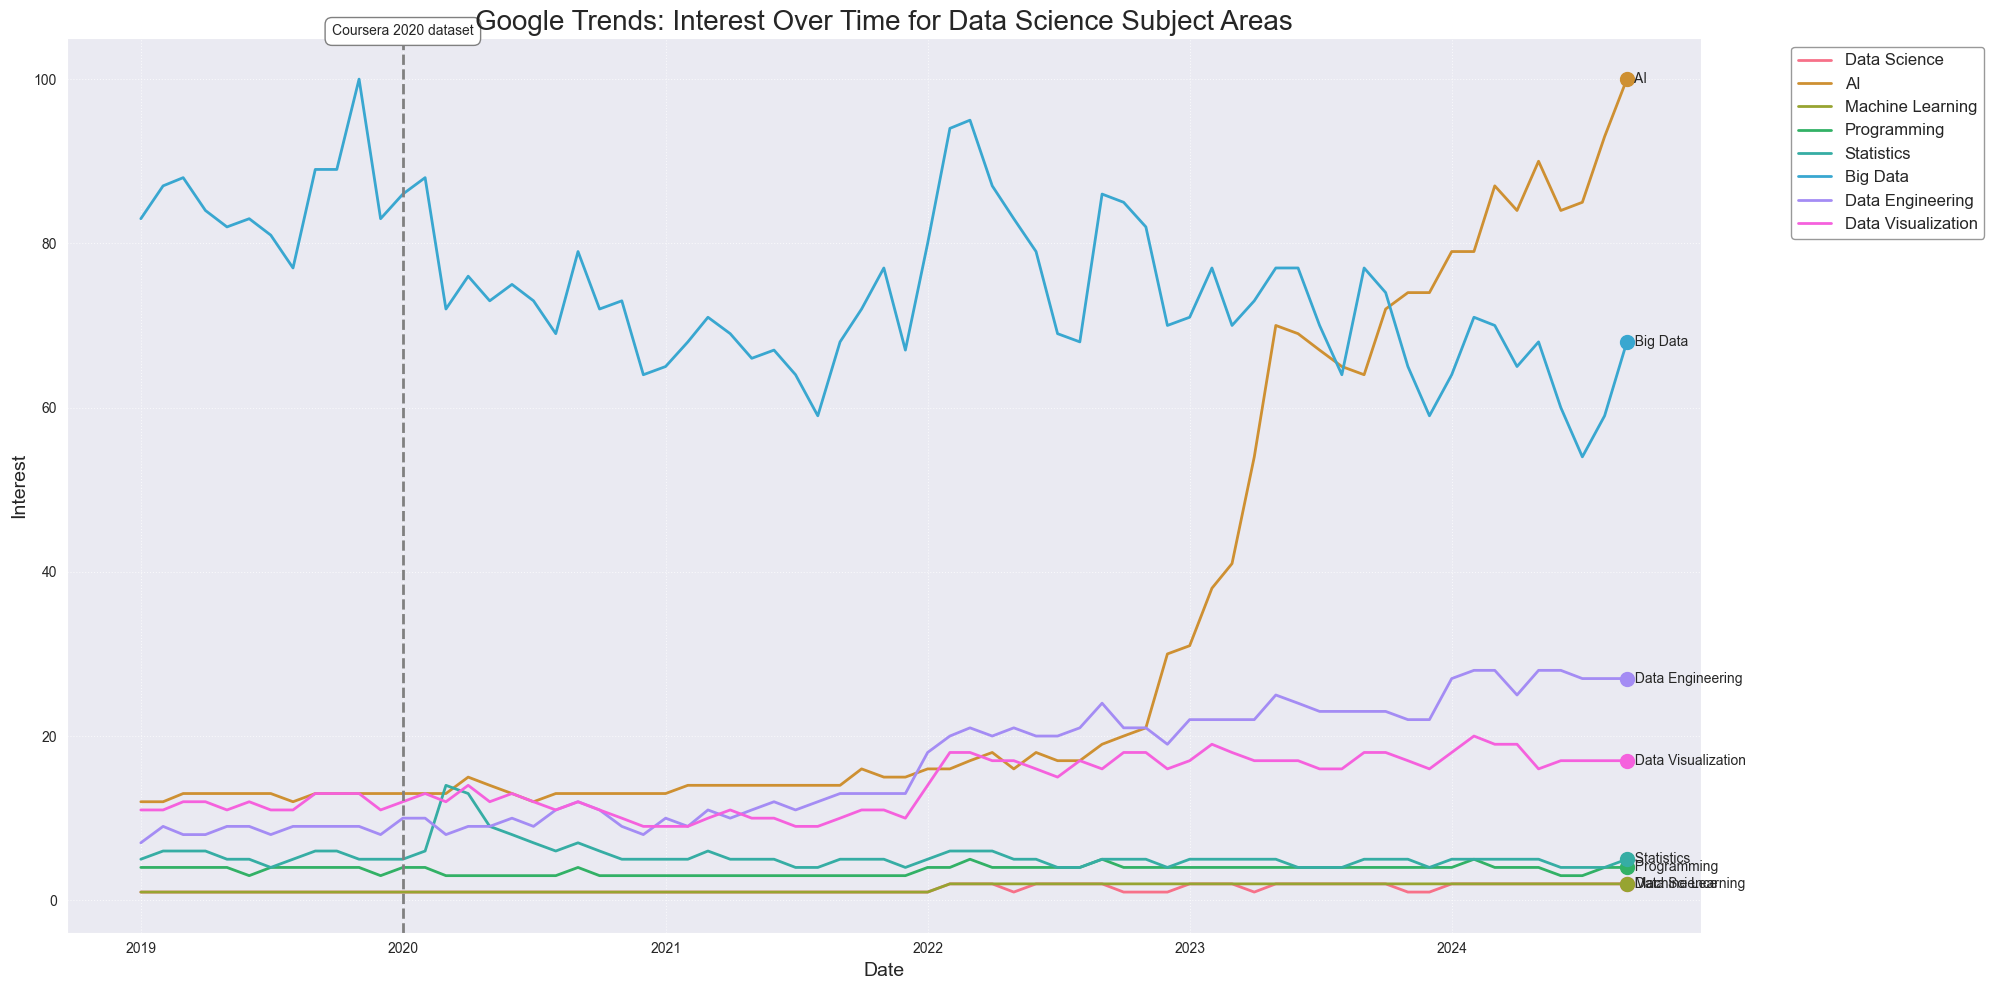

In [38]:
subject_areas = data_science_df['subject_area'].unique().tolist()

pytrends = TrendReq(hl='en-US', tz=360)

timeframe = '2019-01-01 2024-09-30'

all_data = pd.DataFrame()

subject_area_groups = [subject_areas[i:i + 5] for i in range(0, len(subject_areas), 5)]

for group in subject_area_groups:
    pytrends.build_payload(group, cat=0, timeframe=timeframe, geo='', gprop='')
    data = pytrends.interest_over_time()
    if all_data.empty:
        all_data = data
    else:
        all_data = pd.concat([all_data, data.drop('isPartial', axis=1)], axis=1)

# TODO what does this do?
all_data = all_data.drop('isPartial', axis=1)

colors = sns.color_palette("husl", n_colors=len(all_data.columns))
sns.set_palette(colors)

plt.figure(figsize=(20, 10))
for i, column in enumerate(all_data.columns):
    plt.plot(all_data.index, all_data[column], label=column, linewidth=2, color=colors[i])

coursera_date = pd.to_datetime('2020-01-01')
plt.axvline(x=coursera_date, color='gray', linestyle='--', linewidth=2)
plt.text(coursera_date, plt.ylim()[1], 'Coursera 2020 dataset',
         horizontalalignment='center', verticalalignment='bottom',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

plt.title("Google Trends: Interest Over Time for Data Science Subject Areas", fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Interest", fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, frameon=True, facecolor='white', edgecolor='gray')

for i, column in enumerate(all_data.columns):
    plt.plot(all_data.index[-1], all_data[column].iloc[-1], 'o', markersize=10, color=colors[i])
    plt.text(all_data.index[-1], all_data[column].iloc[-1], f"  {column}", verticalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()


- AI and Machine Learning:
  - Substantial increase in interest since 2020, with AI showing the most dramatic rise
  - AI interest has more than doubled since the 2020 dataset, indicating a major shift in focus
- Data Science:
  - Relatively stable interest over time, with a slight decrease since 2020
  - Suggests that while still important, general "data science" may be giving way to more specialized areas
- Programming:
  - Gradual increase in interest since 2020, though not as dramatic as AI
  - Consistent importance in the data science field
- Big Data:
  - Fluctuating interest, with a notable spike around 2022 but a decrease thereafter
  - May indicate evolving focus within the field or integration of big data concepts into other areas
- Data Engineering and Data Visualization:
  - Modest increase in interest since 2020
  - Growing recognition of the importance of these specialized skills in the data science ecosystem
- Statistics:
  - Relatively stable interest, with a slight increase since 2020
  - Continues to be a fundamental area in data science
- Emerging trends:
  - Shift towards AI and machine learning specializations
  - Increased focus on practical skills like data engineering and visualization
  - Potential integration of big data concepts into broader data science curricula
- What is means for course offerings:
  - Need for more advanced AI and machine learning courses to meet growing demand
  - Continued importance of programming courses, with potential focus on AI applications
  - Opportunity to develop specialized courses in data engineering and visualization
  - Potential for interdisciplinary courses that combine multiple subject areas, reflecting the evolving nature of the field

- Limitations of this analysis:
  - Google Trends data reflects search interest, not necessarily course enrollment or job market demand
  - The analysis doesn't account for the quality or depth of available courses in each subject area
  - Regional variations in interest are not captured in this global trend analysis

### Conclusions

## Analysis improvements

- I did not answer due to time: which organizations have the highest-rated courses, and are there subject areas they're not covering? 